#### Plotting Lineage Prevalence

In this example, we will show how to plot the prevalence of a specific lineage from both wastewater and clinical data. Before starting make sure the Python-outbreak-data package is up-to-date and import all necessary plotting and data analysis packages. Here are the ones we used for this plot:

In [47]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)


Authenticate your credentials in GISAID if you haven't done so yet.

In [26]:
from outbreak_data import authenticate_user
authenticate_user.authenticate_new_user()

Please open this url in a web browswer and authenticate with your GISAID credentials:  https://gpsapi.epicov.org/epi3/gps_authenticate/NAJZETKQAROFSFMUHVKTQPVITAKOHMDYPXQSWSZNIIJMHORZQJFNLOJVUETSJVRUHPWXVUJYXUPTFHOMRJTGNTJRYWKKWCYQKGVLFVTMCLFOZXCXHCEFQWMNCLEAXIOO
Waiting for authorization response... [Press Ctrl-C to abort]
Authenication failed, trying again in 5 seconds...
Waiting for authorization response... [Press Ctrl-C to abort]
Authenticated successfully!

    TERMS OF USE for Python Package and
    Reminder of GISAID's Database Access Agreement
    Your ability to access and use Data in GISAID, including your access and
    use of same via R Package, is subject to the terms and conditions of
    GISAID's Database Access Agreement (“DAA”) (which you agreed to
    when you requested access credentials to GISAID), as well as the
    following terms:
    1. You will treat all data contained in the R Package consistent with
    other Data in GISAID and in accordance with GISAID's Da

In [49]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools
from outbreak_tools import outbreak_clustering

In [51]:
# Saves and plots figure
def plot_out(fname):
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show();

# Smooths data for plotting - required
def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])
    
smooth = binom_kernel(7*5, 35) 

#### Pull wastewater and clinical data

First specify the location and date range for analysis and collect the daily lineage and mutation data from the wastewater samples. Then do the same for the clinical data.

In [52]:
state = "California"
state_id = 'USA_US-CA'
startdate, enddate = "2023-09-02", "2024-01-02"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info')
ww_lineages = outbreak_data.get_wastewater_lineages(ww_samples, server='dev.outbreak.info')

In [53]:
ww_prevalences = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1], log=False)
ww_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=1, log=False)
ww_prevalences_daily, ww_prevalences_daily_varis = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, log=False, variance=True)

In [54]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1)
clinical_prevalences = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1])
clinical_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=1, freq='D', log=False)
clinical_prevalences_daily, clinical_prevalences_daily_varis = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=smooth, freq='D', log=False, variance=True)

#### Get the lineage tree data

To group the wastewater data properly for graphing, we need to get lineage data from the pre-parsed lineage tree (derived from the Pangolin project). This will help us organize and cluster lineages later.

In [55]:
tree = outbreak_clustering.get_compressed_tree()
lineage_key = outbreak_clustering.get_lineage_key(tree)

In [56]:
samples_per_site = ww_samples['sra_accession'].groupby(ww_samples['collection_site_id']).nunique()

date_range_per_site = ww_samples.index.to_series().apply(pd.to_datetime).groupby(ww_samples['collection_site_id']) #.apply(pd.to_datetime)
date_range_per_site = date_range_per_site.apply(lambda x: x.max() - x.min())

sites_for_vl = (date_range_per_site.apply(lambda x: x.days >= 14)) & (samples_per_site >= 3)
samples_for_vl = ww_samples[ww_samples['collection_site_id'].isin(list(sites_for_vl.index[sites_for_vl]))]

#### Cluster lineages 

Next we'll need to fetch and aggregate the viral load sample data to get our wastewater prevalence data. 

In [57]:
viral_load = samples_for_vl.set_index(pd.Series(['viral_load'] * len(samples_for_vl)), append=True)

c = 'normed_viral_load'
viral_load_weekly, _ = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='7D', column=c, norm=False, rolling=[1,4,1], log=False, variance=True)
viral_load_weekly = viral_load_weekly['viral_load']

Now we generate clustered groups given our prevalence and lineage tree data.

In [58]:
ww_prev_data = ww_prevalences.mul(viral_load_weekly, axis=0).sum()
clinical_prev_data = clinical_prevalences.mul(viral_load_weekly, axis=0).sum()

ww_clusters = outbreak_clustering.cluster_lineages(ww_prev_data, tree, lineage_key=lineage_key, n=10, alpha=0.25)
cl_clusters = outbreak_clustering.cluster_lineages(clinical_prev_data, tree, lineage_key=lineage_key, n=10, alpha=0.25)

#### Preparing clustered daily prevalence data for plotting

Next we want to apply these clusters to our clustered clinical and wastewater data. We can use this to get daily prevalences for this visual. 

In [72]:
clustered_cl_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_unsmoothed.fillna(0), cl_clusters, tree, lineage_key)
clustered_cl_prevalences_daily, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily.fillna(0), cl_clusters, tree, lineage_key)
clustered_cl_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_varis.fillna(0), cl_clusters, tree, lineage_key, norm=False)

clustered_ww_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_unsmoothed.fillna(0), ww_clusters, tree, lineage_key)
clustered_ww_prevalences_daily, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily.fillna(0), ww_clusters, tree, lineage_key)
clustered_ww_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_varis.fillna(0), ww_clusters, tree, lineage_key, norm=False)

#### Lineage Prevalence Graph

Use this function to ensure the data is normalzed for the graph.

In [ ]:
# Normalizing data 
def lognorm_ci(x, r):
    return (np.exp(np.log(x)-(r**0.5/x)), np.exp(np.log(x)+(r**0.5/x)))

With our clustered wastewater and prevalence data, we can now apply this to any lineage of our choice. We'll pick one from the clinical data set and graph the prevalence data.

In [74]:
lin = clustered_ww_prevalences.columns[-1] # Refers to lineage XBB.1.9.2.5.1.6.1 

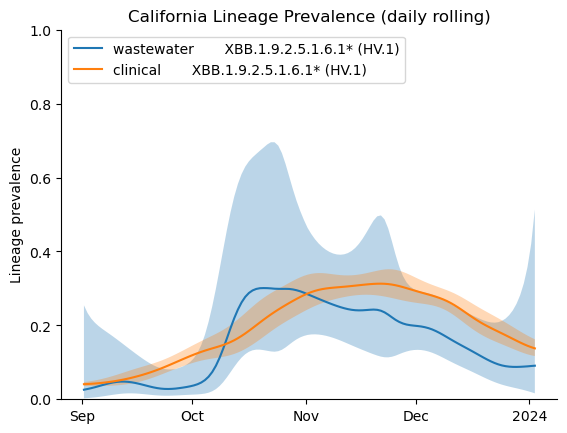

In [75]:
_,ax = plt.subplots()
l,u = lognorm_ci(clustered_ww_prevalences_daily[lin], clustered_ww_prevalences_daily_varis[lin])
ax.plot(clustered_ww_prevalences_daily.index.mid, clustered_ww_prevalences_daily[lin], label=f'wastewater {lin}')
ax.fill_between(clustered_ww_prevalences_daily.index.mid, l, u, alpha=0.3, zorder=-1)

l,u = lognorm_ci(clustered_cl_prevalences_daily[lin], clustered_cl_prevalences_daily_varis[lin])
ax.plot(clustered_cl_prevalences_daily.index.mid, clustered_cl_prevalences_daily[lin], label=f'clinical {lin}')
ax.fill_between(clustered_cl_prevalences_daily.index.mid, l, u, alpha=0.3, zorder=-1)

ax.set_ylim(0, 1)
ax.set_ylabel('Lineage prevalence')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.legend(loc='upper left')
ax.spines[['right', 'top']].set_visible(False)
plt.title(f'{state} Lineage Prevalence (daily rolling)')
plot_out('lin_prev_plot_rolling.pdf')